Autor: Jakub Vlk, xvlkja07
---

# Weibullovo rozdělení
- Weibullovo rozdělení je definováno dvěma parametry:

Weibullovo rozdělení má hustotu pravděpodobnosti a distribuční funkci definovanou následovně:
$$
f(t; \lambda, k) = \frac{k}{\lambda} \left( \frac{t}{\lambda} \right)^{k-1} e^{-(t / \lambda)^k}
$$
Funkce přežití (SF) (pravděpodobnost přežití do času $S(t)$ je definována jako:
$$
S(t; \lambda, k) = e^{-(t / \lambda)^k}
$$

## Výpočet logaritmické věrohodnostní funkce

Věrohodnostní funkce a logaritmická věrohodnostní funkce pro Weibullovo rozdělení jsou definovány následovně:


$$
\mathcal{L}(k, \lambda) = \prod_{i} \left[ \frac{k}{\lambda} \left( \frac{x_i}{\lambda} \right)^{k-1} e^{-\left( \frac{x_i}{\lambda} \right)^k} \right] \prod_{j} \left[ e^{-\left( \frac{x_j}{\lambda} \right)^k} \right]
$$
kde:
- Členy $\sum_i$ ($\prod_i$) zahrnují pouze pozorovaná selhání.
- Členy $\sum_j$ ($\prod_j$)zahrnují pouze pravostranně cenzurované body.


### Logaritmická věrohodnostní funkce pro Weibullovo rozdělení:

$$
\ell(k, \lambda) = \sum_{i} \left[ \ln \frac{k}{\lambda} + (k - 1) \ln \frac{x_i}{\lambda} - \left( \frac{x_i}{\lambda} \right)^k \right] + \sum_{j} \left[ - \left( \frac{x_j}{\lambda} \right)^k \right]
$$
$$
\ell(k, \lambda) = n \ln(k) - n \ln(\lambda) + (k - 1) \sum_{i} \ln(\frac{x_i}{\lambda}) - \sum_{i} \left( \frac{x_i}{\lambda} \right)^k - \sum_{j} \left( \frac{x_j}{\lambda} \right)^k
$$
Výpočet logaritmické věrohodnostní funkce pro Weibullovo rozdělení:


In [1]:
from pydoc import replace

import pandas as pd
import sympy as sp
from mpmath.libmp.libmpf import negative_rnd
from scipy.ndimage import maximum
from sympy.integrals.meijerint_doc import formula

# Načtení Excelového souboru
file_path = "Data_2024.xlsx"
sheet_name = "Data_věrohodnost"  # Název listu, který chcete načíst

# Načtení dat do DataFrame
data = pd.read_excel(file_path, sheet_name=sheet_name, usecols=["censored", "doba práce v oboru [roky]"])

# Přejmenování sloupců
data.columns = ["censored", "time"]

# Náhled na prvních několik řádků
data.describe()

,censored,time
count,321.000000,321.000000
mean,0.274143,6.571389
std,0.446778,1.192638
min,0.000000,2.932000
25%,0.000000,5.830000
50%,0.000000,6.670000
75%,1.000000,7.308000
max,1.000000,9.304000



## Nalezení minima logaritmické věrohodnostní funkce
Nyní je potřeba najít minimum pro nalezení MLE odhadu parametrů $k$ a $\lambda$. V tomto případě to uděláme numericky pomocí optimalizačního algoritmu.
### Derivace podle $k$
$$
\frac{\partial \ell}{\partial k} = \frac{n}{k} + \sum_{i} \ln(x_i) - \sum_{i} \left( \frac{x_i}{\lambda} \right)^k \ln\left( \frac{x_i}{\lambda} \right) - \sum_{j} \left( \frac{x_j}{\lambda} \right)^k \ln\left( \frac{x_j}{\lambda} \right)
$$


### Derivace podle $\lambda$
$$
\frac{\partial \ell}{\partial \lambda} = -\frac{n}{\lambda} + k \sum_{i} \left( \frac{x_i}{\lambda} \right)^k \frac{1}{\lambda} + k \sum_{j} \left( \frac{x_j}{\lambda} \right)^k \frac{1}{\lambda}
$$


In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

failures = data['time'][data['censored'] == 0]
censored_times = data['time'][data['censored'] == 1]


# Log-likelihood function
def llf(n, k, lambd, x_values, y_values):
    term1 = n * np.log(k)
    term2 = -n * k * np.log(lambd)

    term3 = (k - 1) * np.sum(np.log(x_values))

    term4 = -np.sum((x_values / lambd) ** k)

    term5 = -np.sum((y_values / lambd) ** k)
    return term1 + term2 + term3 + term4 + term5


# estimate initial parameters
initial_params = [0.5, np.median(data['time'])]

# Optimalizace
result = minimize(
    fun=lambda params, f, c: -llf(len(f), params[0], params[1], f, c),
    # minus bcs minimizing, f-failrues, c-censored, len(f)-n from the formula
    x0=initial_params,
    args=(failures, censored_times),
    method='L-BFGS-B',  # from docs
    bounds=[(0.001, None), (0.001, None)]  # Lower bounds for k and λ: k > 0, λ > 0
)

# Results:
k_hat, lam_hat = result.x
print("MLE odhad parametrů pomocí scipy.optimize.minimize:")
print(f"Optimal shape parameter k: {k_hat:.3f}")
print(f"Optimal scale parameter λ: {lam_hat:.3f}")

MLE odhad parametrů pomocí scipy.optimize.minimize:
Optimal shape parameter k: 6.173
Optimal scale parameter λ: 7.429


# Je exponenciální rozdělení je postačujícím modelem zapsaných dat?




$$
  H_0: \text{Model je exponenciální ($k=1$)}\quad
$$

$$
H_1: \text{Model je Weibullovo ($k \neq 1$, není exponenciální)}
$$

## MLE pro exponenciální rozdělení

## Pro necenzurovaná data
$$
L(\lambda) = \prod_{i=1}^n \lambda e^{-\lambda x_i}
$$

$$
\ell(\lambda) = \ln L(\lambda) = n \ln \lambda - \lambda \sum_{i=1}^n x_i
$$


## Pro cenzurovaná data

$$
L(\lambda) = \prod_{i=1}^n e^{-\lambda x_i}
$$

$$
\ell(\lambda) = \ln L(\lambda) = - \lambda \sum_{i=1}^n x_i
$$

### Testována hypotéza

$$
\Lambda = -2 \ln \left(\frac{L(H_0)}{L(H_1)}\right) = 2[\ln L(H_0) - \ln L(H_1)].
$$

$$
   p = P(\chi^2(1) \geq \Lambda) = 1 - F_{\chi^2(1)}(\Lambda),
$$


In [3]:
from scipy.stats import chi2


def exponential_log_likelihood_censored(lambda_, censored):
    logL_censored = -lambda_ * np.sum(censored)

    return logL_censored


def exponential_log_likelihood_failed(lambda_, f):
    logL_failures = np.sum(np.log(lambda_) - lambda_ * f)

    return logL_failures


def exponential_log_likelihood(lambda_, f, c):
    return -(exponential_log_likelihood_failed(lambda_, f) + exponential_log_likelihood_censored(lambda_, c))


initial_params = [1.]

result = minimize(exponential_log_likelihood,
                  x0=initial_params,
                  args=(failures, censored_times),
                  method='L-BFGS-B',  # from docs
                  bounds=[(0.001, None)])

lambda_head_exp_num_both = result.x[0]
# Results:
ll_weibull = llf(len(failures), k_hat, lam_hat, failures, censored_times)
ll_exp = -exponential_log_likelihood(lambda_head_exp_num_both, failures, censored_times)

LR = 2 * (ll_weibull - ll_exp)

f"LR statistika: {LR:.3f}, kritická hodnota (alpha 0.05): {chi2.ppf(0.95, 1):.3f}, LR > 3.84: tedy zamítáme H0. Model není exponenciální."


'LR statistika: 592.390, kritická hodnota (alpha 0.05): 3.841, LR > 3.84: tedy zamítáme H0. Model není exponenciální.'

# Bodový odhady:
Vybrané body pro odhad
## Střední hodnota:
$$
E[T] = \lambda \cdot \Gamma\left(1 + \frac{1}{k}\right)
$$

## 10% Percentil:
$$
P(T \leq t) = 0.1
$$
Vyjdeme ze vztahu pro distribuční funkci: $S(t) = 1 - e^{-(t/\lambda)^k}$ a vyřešíme pro $t$:

$$
t = \lambda \cdot (-\ln(1 - p))^{1/k}
$$
$$
t = 7.429 \cdot (-\ln(1 - 0.1))^{1/6.173}
$$

$$
t = 5.16
$$



In [4]:
import numpy as np
from scipy.special import gamma

# Střední doba zaměstnání
mean_weibull = lam_hat * gamma(1 + 1 / k_hat)

# 10% percentil zaměstnání
p = 0.1
percentile_weibull = lam_hat * (-np.log(1 - p)) ** (1 / k_hat)

# Výsledky
print(f"Střední doba (Weibull): {mean_weibull:.2f}")
print(f"10% percentil (Weibull): {percentile_weibull:.2f}")

Střední doba (Weibull): 6.90
10% percentil (Weibull): 5.16


---


# Regrese

Načtení data přejmnování sloupců a náhled na data.

In [5]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import qqplot
from matplotlib import cm

# Načtení Excelového souboru
file_path = "Data_2024.xlsx"
sheet_name = "Data_regrese"  # loaded list name

# Loading to DataFrame
df = pd.read_excel(file_path, sheet_name=sheet_name,
                     usecols=["OSType", "ActiveUsers", "InteractingPct", "ScrollingPct", "Ping [ms]"])

# renaming to more readable names
df.columns = ["os_type", "active_users", "interacting_pct", "scrolling_pct", "ping"]

df_backup = df.copy()

# Quick look at the data
df

,os_type,active_users,interacting_pct,scrolling_pct,ping
0,iOS,4113,0.8283,0.1717,47
1,iOS,7549,0.3461,0.6539,46
2,Windows,8855,0.2178,0.7822,55
3,Android,8870,0.0794,0.9206,56
4,MacOS,9559,0.7282,0.2718,76
...,...,...,...,...,...
497,iOS,5315,0.1974,0.8026,28
498,MacOS,1392,0.2373,0.7627,24
499,iOS,6014,0.8112,0.1888,54
500,Android,5118,0.2345,0.7655,39


Vykrese grafů roložení dat a jejich vztahů pro lepší představu o datech.

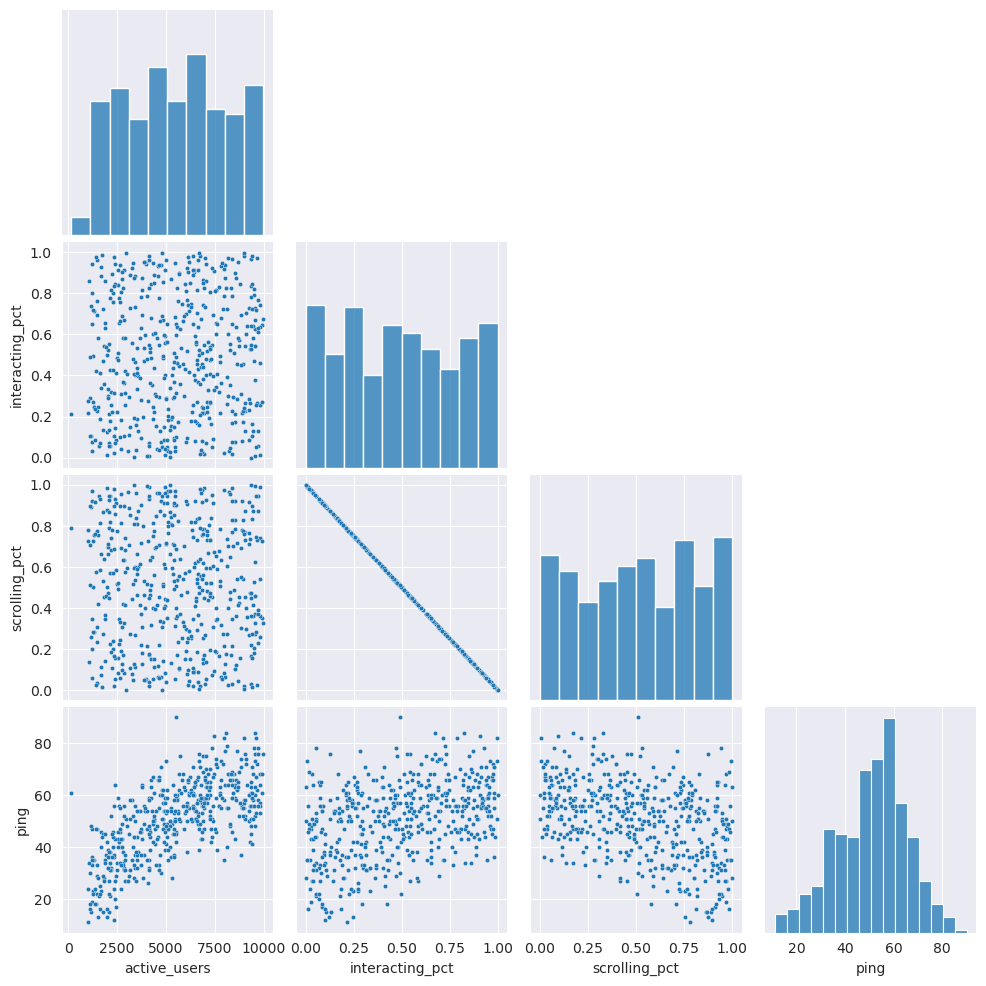

In [6]:
# Ploting of data to see the distribution and relationships directly
pp = sns.pairplot(df, corner=True, plot_kws={"s": 10})

In [7]:
import statsmodels.formula.api as smf


# Definition of simple linear regression model
independent_vars = '+'.join([c for c in df.columns if c != 'ping'])
# ping dependent on every other parameter
formula = f'ping ~ {independent_vars}'

# Regresní model
model = smf.ols(formula=formula, data=df).fit()

# Výstup modelu
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   ping   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     321.5
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          4.75e-153
Time:                        17:06:40   Log-Likelihood:                -1701.8
No. Observations:                 502   AIC:                             3416.
Df Residuals:                     496   BIC:                             3441.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             18.1946      0.669     27.215      0.000      16.881      19.508
os_type[T.MacOS]       9.4307      0.921     10.243      0.000       7.622      11.240
os_type[T.Windows]     3.4142      0.925      3.690      0.000       1.596       5.232
os_type[T.iOS]        -5.7562      0.956     -6.022      0.000      -7.634      -3.878
active_users           0.0039      0.000     30.562      0.000       0.004       0.004
interacting_pct       17.7657      0.655     27.125      0.000      16.479      19.053
scrolling_pct          0.4289      0.628      0.683      0.495      -0.805       1.663
==============================================================================
Omnibus:                       21.030   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.525
Skew:                           0.042   Prob(JB):                     1.45e-12
Kurtosis:                       4.612   Cond. No.                     3.07e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.95e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Z tabulky jde vidět že P hodnota sloupce scrolling_pct je větší jak 0.05, tak je možné tento sloupec odstranit.

In [8]:
# Removing the column with high p-value
df.drop(columns=['scrolling_pct'], inplace=True,axis=1)

# Definition of simple linear regression model
independent_vars = '+'.join([c for c in df.columns if c != 'ping'])
# ping dependent on every other parameter
formula = f'ping ~ {independent_vars}'

# Regresní model
model = smf.ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   ping   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     321.5
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          4.75e-153
Time:                        17:06:40   Log-Likelihood:                -1701.8
No. Observations:                 502   AIC:                             3416.
Df Residuals:                     496   BIC:                             3441.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             18.6234      1.120     16.629      0.000      16.423      20.824
os_type[T.MacOS]       9.4307      0.921     10.243      0.000       7.622      11.240
os_type[T.Windows]     3.4142      0.925      3.690      0.000       1.596       5.232
os_type[T.iOS]        -5.7562      0.956     -6.022      0.000      -7.634      -3.878
active_users           0.0039      0.000     30.562      0.000       0.004       0.004
interacting_pct       17.3369      1.096     15.825      0.000      15.184      19.489
==============================================================================
Omnibus:                       21.030   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.525
Skew:                           0.042   Prob(JB):                     1.45e-12
Kurtosis:                       4.612   Cond. No.                     2.98e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.98e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Nyní přejdu k plně kvadratickému modelu.

In [9]:
# Adding basic terms
columns_without_ping = [c for c in df.columns if c != 'ping']

independent_vars = '+'.join([c for c in columns_without_ping])
independent_vars += "+"
# Adding quadratic terms
independent_vars += '+'.join([f'{c} + I({c}**2)' for c in columns_without_ping if c != 'os_type'])
independent_vars += "+"
# Adding interaction terms double for each pair
independent_vars += "+".join([f'{c}:{c2}' for c in columns_without_ping for c2 in columns_without_ping ])


# ping dependent on every other parameter
formula = f'ping ~ {independent_vars}'

# Regresní model
model = smf.ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     187.9
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          5.18e-186
Time:                        17:06:40   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3227.
Df Residuals:                     487   BIC:                             3290.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -0.3388      2.354     -0.144      0.886      -4.965       4.287
os_type[T.MacOS]                       2.0017      2.260      0.886      0.376      -2.440       6.443
os_type[T.Windows]                     7.8174      2.217      3.526      0.000       3.461      12.174
os_type[T.iOS]                        -0.0483      2.265     -0.021      0.983      -4.499       4.403
active_users                           0.0100      0.001     17.571      0.000       0.009       0.011
os_type[T.MacOS]:active_users          0.0014      0.000      4.536      0.000       0.001       0.002
os_type[T.Windows]:active_users       -0.0008      0.000     -2.505      0.013      -0.001      -0.000
os_type[T.iOS]:active_users           -0.0011      0.000     -3.369      0.001      -0.002      -0.000
interacting_pct                       37.6062      4.567      8.234      0.000      28.633      46.580
os_type[T.MacOS]:interacting_pct      -0.3566      2.530     -0.141      0.888      -5.327       4.614
os_type[T.Windows]:interacting_pct     0.4260      2.721      0.157      0.876      -4.919       5.771
os_type[T.iOS]:interacting_pct         0.2678      2.691      0.100      0.921      -5.020       5.556
I(active_users ** 2)                -4.17e-07    4.4e-08     -9.469      0.000   -5.03e-07    -3.3e-07
I(interacting_pct ** 2)               -3.7258      3.492     -1.067      0.287     -10.587       3.135
active_users:interacting_pct          -0.0031      0.000     -8.532      0.000      -0.004      -0.002
==============================================================================
Omnibus:                      228.442   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3152.488
Skew:                           1.603   Prob(JB):                         0.00
Kurtosis:                      14.851   Cond. No.                     1.06e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
# shamefully stolen from practice

X = pd.DataFrame(model.model.exog, columns=model.model.exog_names)
vif = pd.Series([variance_inflation_factor(X.values, i)
                 for i in range(X.shape[1])],
                 index=X.columns)
vif_df = vif.to_frame()
# Nastavení názvu sloupce
vif_df.columns = ['VIF']
print(vif_df)

                                          VIF
Intercept                           79.081437
os_type[T.MacOS]                    14.530955
os_type[T.Windows]                  13.726080
os_type[T.iOS]                      13.164975
active_users                        30.108570
os_type[T.MacOS]:active_users       10.454073
os_type[T.Windows]:active_users     10.189613
os_type[T.iOS]:active_users          9.061267
interacting_pct                     26.021105
os_type[T.MacOS]:interacting_pct     7.586537
os_type[T.Windows]:interacting_pct   6.857633
os_type[T.iOS]:interacting_pct       6.028016
I(active_users ** 2)                22.499134
I(interacting_pct ** 2)             16.060875
active_users:interacting_pct         8.851002


Hodnoty větší jak 10 mohu indikovat vysokou korealitu. Standardizuji je teda pomocí z-score. Zde by bylo asi fajn podotknout to, že pokud by se do modelu přidávali další data, tak je potřeba nová data taktéř normalizovat.

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df['active_users'] = scaler.fit_transform(df[['active_users']])
df['interacting_pct'] = scaler.fit_transform(df[['interacting_pct']])

# formula is still the same
model = smf.ols(formula=formula, data=df).fit()

X = pd.DataFrame(model.model.exog, columns=model.model.exog_names)
vif = pd.Series([variance_inflation_factor(X.values, i)
                 for i in range(X.shape[1])],
                 index=X.columns)
vif_df = vif.to_frame()
# Nastavení názvu sloupce
vif_df.columns = ['VIF']
print('\n\n\n')
print(vif_df)





                                         VIF
Intercept                           6.781856
os_type[T.MacOS]                    1.654677
os_type[T.Windows]                  1.630480
os_type[T.iOS]                      1.606613
active_users                        4.918200
os_type[T.MacOS]:active_users       2.335540
os_type[T.Windows]:active_users     2.383411
os_type[T.iOS]:active_users         2.247663
interacting_pct                     4.737489
os_type[T.MacOS]:interacting_pct    2.503341
os_type[T.Windows]:interacting_pct  2.092440
os_type[T.iOS]:interacting_pct      2.198356
I(active_users ** 2)                1.019635
I(interacting_pct ** 2)             1.032984
active_users:interacting_pct        1.041103


Jak je vidno výše, normalizace výšše zmíněných data pomohla dostat hodnoty VIF pod 10.

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     187.9
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          5.18e-186
Time:                        17:06:40   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3227.
Df Residuals:                     487   BIC:                             3290.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             51.3157      0.689     74.429      0.000      49.961      52.670
os_type[T.MacOS]                       9.4931      0.763     12.445      0.000       7.994      10.992
os_type[T.Windows]                     3.8461      0.764      5.033      0.000       2.344       5.348
os_type[T.iOS]                        -5.7234      0.791     -7.232      0.000      -7.278      -4.168
active_users                          10.0359      0.587     17.093      0.000       8.882      11.189
os_type[T.MacOS]:active_users          3.5582      0.784      4.536      0.000       2.017       5.099
os_type[T.Windows]:active_users       -1.9400      0.774     -2.505      0.013      -3.461      -0.419
os_type[T.iOS]:active_users           -2.6950      0.800     -3.369      0.001      -4.267      -1.123
interacting_pct                        5.0371      0.576      8.741      0.000       3.905       6.169
os_type[T.MacOS]:interacting_pct      -0.1054      0.748     -0.141      0.888      -1.575       1.364
os_type[T.Windows]:interacting_pct     0.1260      0.804      0.157      0.876      -1.455       1.707
os_type[T.iOS]:interacting_pct         0.0792      0.796      0.100      0.921      -1.485       1.643
I(active_users ** 2)                  -2.7037      0.286     -9.469      0.000      -3.265      -2.143
I(interacting_pct ** 2)               -0.3258      0.305     -1.067      0.287      -0.926       0.274
active_users:interacting_pct          -2.3239      0.272     -8.532      0.000      -2.859      -1.789
==============================================================================
Omnibus:                      228.442   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3152.488
Skew:                           1.603   Prob(JB):                         0.00
Kurtosis:                      14.851   Cond. No.                         9.66
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Ze detailu ohled modelu jde vidět, že některé hodnoty mají vysokou p hodnotu. Tyto hodnoty jsem eliminoval.


In [13]:
# Removing columns with high p-value

# Adding basic terms
columns_without_ping = [c for c in df.columns if c != 'ping']

independent_vars = '+'.join([c for c in columns_without_ping])
independent_vars += "+"
# Adding quadratic terms
independent_vars += '+'.join([f'{c} + I({c}**2)' for c in columns_without_ping if c != 'os_type' and c != 'interacting_pct'])
independent_vars += "+"
# Adding interaction terms double for each pair

# please dont judge me for this
columns_without_inter = [c for c in columns_without_ping if c != 'interacting_pct']
columns_without_inter_ostype = [c for c in columns_without_inter if c != 'os_type']
independent_vars += "+".join([f'{c}:{c2}' for c in columns_without_ping for c2 in columns_without_inter_ostype])

# ping dependent on every other parameter
formula = f'ping ~ {independent_vars}'


X = pd.DataFrame(model.model.exog, columns=model.model.exog_names)
vif = pd.Series([variance_inflation_factor(X.values, i)
                 for i in range(X.shape[1])],
                 index=X.columns)
vif_df = vif.to_frame()
# Nastavení názvu sloupce
vif_df.columns = ['VIF']
print('\n\n\n')
print(vif_df)

# Regresní model
model = smf.ols(formula=formula, data=df).fit()
model.summary()





                                         VIF
Intercept                           6.781856
os_type[T.MacOS]                    1.654677
os_type[T.Windows]                  1.630480
os_type[T.iOS]                      1.606613
active_users                        4.918200
os_type[T.MacOS]:active_users       2.335540
os_type[T.Windows]:active_users     2.383411
os_type[T.iOS]:active_users         2.247663
interacting_pct                     4.737489
os_type[T.MacOS]:interacting_pct    2.503341
os_type[T.Windows]:interacting_pct  2.092440
os_type[T.iOS]:interacting_pct      2.198356
I(active_users ** 2)                1.019635
I(interacting_pct ** 2)             1.032984
active_users:interacting_pct        1.041103


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   ping   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     264.4
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          1.69e-190
Time:                        17:06:40   Log-Likelihood:                -1599.1
No. Observations:                 502   AIC:                             3220.
Df Residuals:                     491   BIC:                             3267.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          51.0013      0.620     82.217      0.000      49.782      52.220
os_type[T.MacOS]                    9.4142      0.757     12.438      0.000       7.927      10.901
os_type[T.Windows]                  3.8746      0.761      5.090      0.000       2.379       5.370
os_type[T.iOS]                     -5.7581      0.787     -7.319      0.000      -7.304      -4.212
active_users                       10.0047      0.584     17.124      0.000       8.857      11.153
os_type[T.MacOS]:active_users       3.6143      0.780      4.633      0.000       2.082       5.147
os_type[T.Windows]:active_users    -1.8764      0.768     -2.442      0.015      -3.386      -0.367
os_type[T.iOS]:active_users        -2.6289      0.795     -3.306      0.001      -4.191      -1.067
interacting_pct                     5.0348      0.266     18.931      0.000       4.512       5.557
I(active_users ** 2)               -2.6981      0.285     -9.480      0.000      -3.257      -2.139
interacting_pct:active_users       -2.3278      0.269     -8.662      0.000      -2.856      -1.800
==============================================================================
Omnibus:                      230.750   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3263.977
Skew:                           1.617   Prob(JB):                         0.00
Kurtosis:                      15.066   Cond. No.                         8.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Hodnoty p jsou již všechny pod 0.05, což znamená že v modelu jsou pouze statisticky významné hodnoty. Nyní ještě do modelu vrátím původní hodnoty.

In [14]:
df['active_users'] = df_backup['active_users']
df['interacting_pct'] = df_backup['interacting_pct']

# Regresní model
model = smf.ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   ping   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     264.4
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          1.69e-190
Time:                        17:06:40   Log-Likelihood:                -1599.1
No. Observations:                 502   AIC:                             3220.
Df Residuals:                     491   BIC:                             3267.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           0.3193      2.061      0.155      0.877      -3.731       4.369
os_type[T.MacOS]                    1.6278      1.891      0.861      0.390      -2.087       5.343
os_type[T.Windows]                  7.9171      1.870      4.235      0.000       4.244      11.590
os_type[T.iOS]                     -0.0944      1.894     -0.050      0.960      -3.816       3.627
active_users                        0.0100      0.001     17.617      0.000       0.009       0.011
os_type[T.MacOS]:active_users       0.0014      0.000      4.633      0.000       0.001       0.002
os_type[T.Windows]:active_users    -0.0007      0.000     -2.442      0.015      -0.001      -0.000
os_type[T.iOS]:active_users        -0.0010      0.000     -3.306      0.001      -0.002      -0.000
interacting_pct                    33.9861      2.123     16.006      0.000      29.814      38.158
I(active_users ** 2)            -4.161e-07   4.39e-08     -9.480      0.000   -5.02e-07    -3.3e-07
interacting_pct:active_users       -0.0031      0.000     -8.662      0.000      -0.004      -0.002
==============================================================================
Omnibus:                      230.750   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3263.977
Skew:                           1.617   Prob(JB):                         0.00
Kurtosis:                      15.066   Cond. No.                     5.66e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.66e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:

# Outliers detection
influence = model.get_influence()
outl_stats_df = pd.DataFrame({
    'Standardized Residuals': influence.resid_studentized_internal,
}, index=df.index)
outl_stats_df = outl_stats_df[(np.abs(outl_stats_df['Standardized Residuals']) > 5)]

print(outl_stats_df)

index = outl_stats_df.index # [255, 476]

     Standardized Residuals
255                5.945469
476                8.830417


Výše uvedený kód detekuje outliery. Používá se k tomu metrika resid_studentized_internal, která označuje standardizované reziduum (chybu) každého bodu, přičemž se zohledňuje jeho vliv na model. Hodnoty s větším číslem považuju za outliery. Výše uvedený kód detekuje dva outliery, které jsou na indexech 255 a 476. Nyní se podívám na grafy, které mi pomohou zjistit, zda jsou tyto body opravdu outliery.

Text(612.6199494949494, 0.5, 'Rezidua')

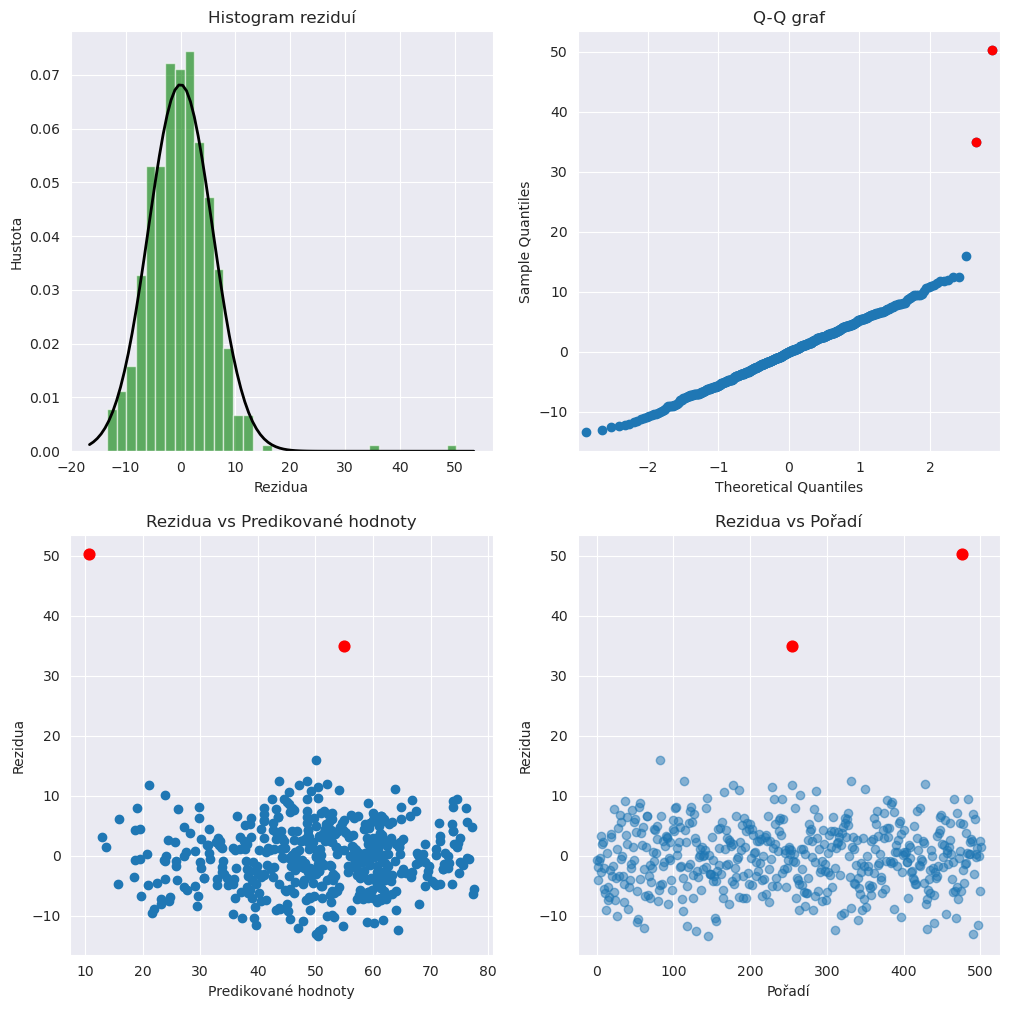

In [16]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12))

# Vykreslení histogramu reziduí - pro málo pozorování moc nedává smysl
ax1.hist(model.resid, bins='auto', density=True, alpha=0.6, color='g')


# Vykreslení odpovídající Gaussovy křivky
xmin, xmax, _, _ = ax1.axis()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(model.resid), np.std(model.resid))
ax1.plot(x, p, 'k', linewidth=2)
ax1.grid(True)
ax1.set_title("Histogram reziduí")
ax1.set_xlabel("Rezidua")
ax1.set_ylabel("Hustota")


#q-q plot
qqplot(model.resid, ax=ax2)
ax2.scatter([2.65,2.88], model.resid[[255, 476]], color='red', zorder=5) # psst, shame on me...
ax2.set_title('Q-Q graf')
ax2.grid(True)

#res vs fit
ax3.scatter(model.fittedvalues, model.resid)
ax3.scatter(model.fittedvalues[index], model.resid[index], color='r', s=60)
ax3.grid(True)
ax3.set_xlabel('Predikované hodnoty')
ax3.set_ylabel('Rezidua')
ax3.set_title('Rezidua vs Predikované hodnoty')

# res vs order
ax4.scatter(range(len(model.resid)), model.resid, alpha=0.5)
ax4.grid(True)
plt.scatter(index, model.resid[index], color='r', s=60)
plt.savefig("residuals.png")
ax4.set_title("Rezidua vs Pořadí")
ax4.set_xlabel("Pořadí")
ax4.set_ylabel("Rezidua")

I když jsem skoro nespal tak lze jen těžko pochybovat, že by v body vybrané výše nebyli outliery a že bych je odstranil neprávem. Body tedy odstraním a zkontrololuju zda jsem odstranil správné body. Výsledek je **Diagnostika** modelu. Hodnoty jsou uvěřitelné, ale přišliš komplikují tvorbu dobrého modelu

Text(612.6199494949494, 0.5, 'Rezidua')

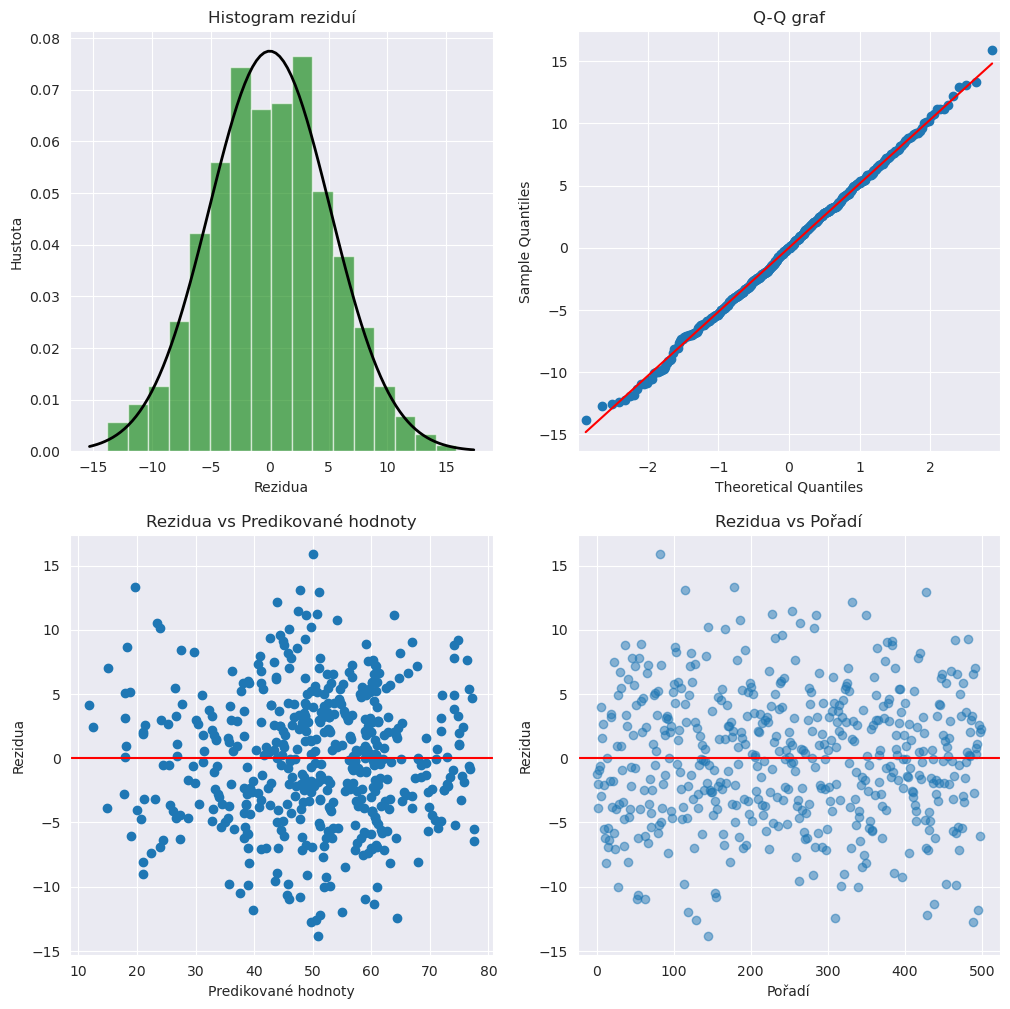

In [17]:
df = df.drop(index)

model = smf.ols(formula=formula, data=df).fit()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12))

# Vykreslení histogramu reziduí - pro málo pozorování moc nedává smysl
ax1.hist(model.resid, bins='auto', density=True, alpha=0.6, color='g')


# Vykreslení odpovídající Gaussovy křivky
xmin, xmax, _, _ = ax1.axis()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(model.resid), np.std(model.resid))
ax1.plot(x, p, 'k', linewidth=2)
ax1.grid(True)
ax1.set_title("Histogram reziduí")
ax1.set_xlabel("Rezidua")
ax1.set_ylabel("Hustota")


#q-q plot
qqplot(model.resid, ax=ax2,   line='s', linewidth=2)
ax2.set_title('Q-Q graf')
ax2.grid(True)

#res vs fit
ax3.scatter(model.fittedvalues, model.resid)
ax3.axhline(y=0, color='r', linestyle='-')
ax3.grid(True)
ax3.set_xlabel('Predikované hodnoty')
ax3.set_ylabel('Rezidua')
ax3.set_title('Rezidua vs Predikované hodnoty')

# res vs order
ax4.scatter(range(len(model.resid)), model.resid, alpha=0.5)
ax4.axhline(y=0, color='r', linestyle='-')
ax4.grid(True)
plt.savefig("residuals.png")
ax4.set_title("Rezidua vs Pořadí")
ax4.set_xlabel("Pořadí")
ax4.set_ylabel("Rezidua")

In [18]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   ping   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     349.9
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          1.28e-215
Time:                        17:06:42   Log-Likelihood:                -1528.7
No. Observations:                 500   AIC:                             3079.
Df Residuals:                     489   BIC:                             3126.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -1.8398      1.832     -1.004      0.316      -5.439       1.759
os_type[T.MacOS]                   -0.5427      1.677     -0.324      0.746      -3.838       2.753
os_type[T.Windows]                  7.7823      1.646      4.729      0.000       4.549      11.016
os_type[T.iOS]                      0.1798      1.667      0.108      0.914      -3.096       3.455
active_users                        0.0107      0.001     21.064      0.000       0.010       0.012
os_type[T.MacOS]:active_users       0.0017      0.000      6.415      0.000       0.001       0.002
os_type[T.Windows]:active_users    -0.0008      0.000     -2.827      0.005      -0.001      -0.000
os_type[T.iOS]:active_users        -0.0011      0.000     -3.915      0.000      -0.002      -0.001
interacting_pct                    35.9786      1.879     19.146      0.000      32.286      39.671
I(active_users ** 2)             -4.63e-07   3.91e-08    -11.832      0.000    -5.4e-07   -3.86e-07
interacting_pct:active_users       -0.0034      0.000    -10.752      0.000      -0.004      -0.003
==============================================================================
Omnibus:                        0.661   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.719   Jarque-Bera (JB):                0.750
Skew:                           0.014   Prob(JB):                        0.687
Kurtosis:                       2.812   Cond. No.                     5.66e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.66e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Diagnostik**
R-squared (R²): 0.877 - Vysvětluje 87,7 % variability závislé proměnné ping, což naznačuje velmi dobré přizpůsobení datům.
Adj. R-squared: 0.875 - Korekce na počet prediktorů je minimální, což naznačuje, že přidání proměnných bylo relevantní.
F-statistic: 349.9 (p-hodnota < 1.28e-215) - Model jako celek je statisticky signifikantní.

*Normální rozdělení reziduí:*
- Omnibus test: 0.661 (p = 0.719)
- Jarque-Bera (JB): 0.750 (p = 0.687)
    - Obě testové statistiky naznačují, že rezidua nemají významné odchylky od normálního rozdělení.
- Skew (Šikmost): 0.014
- Kurtosis (Špičatost): 2.812
- Rezidua jsou lehce špičatá, ale v mezích normálního rozdělení.


Tímto považuju model za hotový. Zjevně odstranění outlierů pomohlo modelu. Výsledný model je statisticky významný a všechny hodnoty jsou pod 0.05 (Při normalizovaných datech!). Denormalizaci jsem provedl, abych na to nemusel myslet později.

P-hodnota není vždy jediným ukazatelem kvality modelu, zvláště pokud máme malý vzorek nebo když je důležitější praktická významnost a robustnost modelu než striktní dodržování prahu 0.05. Pokud model dobře funguje po odstranění outlierů a poskytuje smysluplné predikce(jak bude vidno níže), p-hodnoty nad 0.05 nemusí být klíčové pro jeho validitu.


In [19]:
coefficients = model.params

# crafting the equation
equation = "y = "
equation += " + ".join([f"{coef:.4f}*{replace(var, ":", "*")}" if var != "Intercept" else f"{coef:.4f}" for var, coef in coefficients.items()])

print(equation)

y = -1.8398 + -0.5427*os_type[T.MacOS] + 7.7823*os_type[T.Windows] + 0.1798*os_type[T.iOS] + 0.0107*active_users + 0.0017*os_type[T.MacOS]*active_users + -0.0008*os_type[T.Windows]*active_users + -0.0011*os_type[T.iOS]*active_users + 35.9786*interacting_pct + -0.0000*I(active_users ** 2) + -0.0034*interacting_pct*active_users


Vzniklý model lze vidět ve výpisu předešlého bloku.

In [20]:
predictions = model.predict(df)

df['Predicted'] = predictions

max_pred = df.loc[df['Predicted'].idxmax()]

print("Nastavení parametrů s nejvyšší predikovanou hodnotou:")
print(max_pred)

Nastavení parametrů s nejvyšší predikovanou hodnotou:
os_type                MacOS
active_users            9657
interacting_pct        0.973
ping                      72
Predicted          77.504628
Name: 10, dtype: object


In [23]:
avg_values = df[df['os_type'] == "Windows"].drop('os_type', axis=1).mean()


tmp_df_mean = pd.DataFrame({
    'active_users': [avg_values['active_users']],
    'interacting_pct': [avg_values['interacting_pct']],
    'os_type': "Windows"
})


# Prediction of the ping for the average Windows user (with 95% confidence interval)
predicted_windows = model.get_prediction(tmp_df_mean).summary_frame(1-0.95)


confidence_interval_lower = predicted_windows.iloc[0]['mean_ci_lower']
confidence_interval_upper = predicted_windows.iloc[0]['mean_ci_upper']

prediction_interval_lower = predicted_windows.iloc[0]['obs_ci_lower']
prediction_interval_upper = predicted_windows.iloc[0]['obs_ci_upper']

print("Konfidečníni interval se spolehlivosti 95%: <" + str(confidence_interval_lower)\
      + ", " + str(confidence_interval_upper) + ">")
print("Predikcni interval se spolehlivosti 95%: <" + str(prediction_interval_lower)\
      + ", " + str(prediction_interval_upper) + ">")

print("Predikovany ping: " + str(predicted_windows.iloc[0]['mean']))

Konfidečníni interval se spolehlivosti 95%: <53.825074148475224, 55.8863563291313>
Predikcni interval se spolehlivosti 95%: <44.577709516025855, 65.13372096158068>
Predikovany ping: 54.85571523880326


Výpočet hodnoty odezvy uživatele s Windows, při průměrném nastavení ostatních spolu s výpočtem parametrů a vypočtětem konfidenčního intervalu a predikčního interval pro toto nastavení. Je realizován tak že je vytvořen df. pro požadované hodnoty (průměrné hodnoty pro Windows) a následně je použit model.get_prediction() pro výpočet intervalů a hodnoty.


# Závěr:
Vyrobený model se zdá že je schopný uvěřitelně předpovídat hodnoty. Problém modelu je, ale to, že nemáme moc hodnot. Lze se na to dívat statisticky a to sice tak, že to není dostatek hodnot na kvalitní predikce. Hodilo by se mi dostatek dat na vytvoření více modelů z části dat a následně porovnání jejich výsledků, tedy podobný princip jako v ML kde se data rozdělí na trénovací a testovací data (a případně validační).

Pokud se podíváme na `model.summary()` tak můžeme videt `R-squared: 0.87` což znamená že model vysvětluje ~88% variability dat. To je dobrý výsledek, vzhledem k tomu, že máme jen 500 hodnot.

Ačkoliv je příklad náhodný a nemusí dávat smysl tak by se asi hodilo i uvážit to, že jakožto konkurence twitteru nebo facebooku by jsme chtěli miliony uživatelů. Protože by jsem rádiu testovali co se stane s odevzvou při milionech užitevatelů a i více .
